#Project work NLP
Authors:
* Nicola Carrassi, ID: 0001037813 nicola.carrassi@studio.unibo.it
* Gabriele Colasuonno, ID: 0001037489 gabriele.colasuonno@studio.unibo.it
* Antonio Guerra, ID: 0001037365 antonio.guerra7@studio.unibo.it

## Libraries import and installation

In [ ]:
%%capture
!pip install contractions
!pip install textgenie
!pip install nltk
!pip install spacy
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install xgboost 
!pip install scikit-multilearn

In [ ]:
import os
import re
import sys
import random
import string
import contractions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request

from tqdm import tqdm
from typing import List, Callable

from google.colab import drive
from google.colab import files
from collections import Counter
from itertools import chain

#data augmentation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy #utility for lemmatization

nltk.download('stopwords')
nltk.download('omw-1.4')
from textgenie import TextGenie

import sklearn.metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBRFClassifier
from skmultilearn.problem_transform import LabelPowerset

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
import datasets
from datasets import Features, Value, Sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
sys.path.append('content/')

PROJECT_WORK_LOCAL_PATH = '/content/gdrive/MyDrive/unibo/NLP/projectWork'
drive.mount('/content/gdrive', force_remount=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive


## Reproducibility
Reproducibility is essential for correct evaluation. So, we are setting 42 as the random seed for all sources of randomness.

In [ ]:
RANDOM_SEED = 42

def set_reproducibility(seed: int):
    """
    Set the same random seed to different sources of randomness

    :param seed: random seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_reproducibility(RANDOM_SEED)

##Data preparation

In this section there are all the operations which go from the downloading of the dataset to the final save of the datasets which will be used for training, validation and test.

###Dataset download

In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.tsv')

    if not os.path.exists(data_path):
        print(f"Downloading {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

Since the test set provided by the authors of the challenge hasn't got the gold standard labels, we will use the validation set as our test set and split the original training set in training and validation set as follows:


1.   80% of the original training set will be the new training set
2.   The remaining 20% will be used as validation set

In [ ]:
DATASET_FOLDER = 'touche23'

# Train data
train_arguments_url = "https://zenodo.org/record/7402070/files/arguments-training.tsv?download=1"
train_labels_url = "https://zenodo.org/record/7402070/files/labels-training.tsv?download=1"
download_data(data_path=DATASET_FOLDER, url_path=train_arguments_url, suffix='train_arguments')
download_data(data_path=DATASET_FOLDER, url_path=train_labels_url, suffix='train_labels')

# test data
test_arguments_url = "https://zenodo.org/record/7402070/files/arguments-validation.tsv?download=1"
test_labels_url = "https://zenodo.org/record/7402070/files/labels-validation.tsv?download=1"
download_data(data_path=DATASET_FOLDER, url_path=test_arguments_url, suffix='test_arguments')
download_data(data_path=DATASET_FOLDER, url_path=test_labels_url, suffix='test_labels')


'''
# Test data
test_arguments_url = "https://zenodo.org/record/7402070/files/arguments-test.tsv?download=1"
download_data(data_path=DATASET_FOLDER, url_path=test_arguments_url, suffix='test_arguments')
'''

arguments-training.tsv?download=1: 1.02MB [00:04, 243kB/s]                           


Download completed!


labels-training.tsv?download=1: 254kB [00:02, 116kB/s]                           


Download completed!


arguments-validation.tsv?download=1: 369kB [00:02, 150kB/s]                           


Download completed!


labels-validation.tsv?download=1: 90.1kB [00:01, 55.8kB/s]                            

Download completed!


'\n# Test data\ntest_arguments_url = "https://zenodo.org/record/7402070/files/arguments-test.tsv?download=1"\ndownload_data(data_path=DATASET_FOLDER, url_path=test_arguments_url, suffix=\'test_arguments\')\n'

###Dataset encoding
Encode the dataset using Pandas dataframes

In [ ]:
def encode_dataset(path_arguments : str, path_labels : str) -> pd.DataFrame:
  """
  The function allows to encode a dataset, reading it from a given url and 
  encoding it with its gold standard label if available

  :param path_arguments: path of the table in which are stored the features
  :param path_labels:  path of the table in which are stored the labels of the data,
    if the labels are not available it can be set to None

  :return arguments_df: encoded DataFrame
  """  
  arguments_df = pd.read_table(path_arguments)

  if path_labels != None:
    labels_df = pd.read_table(path_labels)
    assert len(arguments_df) == len(labels_df)
    labels = []
    for i in range(len(arguments_df)):
      labels.append(labels_df.iloc[i].to_numpy()[1:])

    arguments_df['labels'] = labels
  
  else:
    arguments_df['labels'] = np.nan
   
  return arguments_df

In [ ]:
df_train = encode_dataset(DATASET_FOLDER + '/train_arguments.tsv', DATASET_FOLDER+'/train_labels.tsv')
df_train, df_val = train_test_split(df_train, test_size=0.2)
df_test = encode_dataset(DATASET_FOLDER + '/test_arguments.tsv', DATASET_FOLDER+'/test_labels.tsv')

print('Dataset splits statistics: ')
print(f'Train data shape: {df_train.shape}')
print(f'Validation data shape: {df_val.shape}')
print(f'Test data shape: {df_test.shape}')

Dataset splits statistics: 
Train data shape: (4314, 5)
Validation data shape: (1079, 5)
Test data shape: (1896, 5)


Some example from training set

In [ ]:
df_train.head()

,Argument ID,Conclusion,Stance,Premise,labels
2312,A22488,We should subsidize Wikipedia,in favor of,wikipedia provides an endless amount of inform...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4145,A29229,We should ban cosmetic surgery,in favor of,banning cosmetic surgery and obligatory becaus...,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."
2807,A24243,We should introduce compulsory voting,against,we should not introduce compulsory voting beca...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
621,A12490,We should abolish the right to keep and bear arms,in favor of,the right to keep and bear arms should be abol...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."
566,A12398,We should end the use of economic sanctions,against,economic sanctions do help western countries t...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."


Some example from validation set

In [ ]:
df_val.head()

,Argument ID,Conclusion,Stance,Premise,labels
2780,A24197,We should adopt a zero-tolerance policy in sch...,in favor of,the security of child and teachers is esential...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."
1047,A19059,We should adopt a multi-party system,in favor of,multi-party systems provide many new sources o...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3614,A27387,We should abolish zoos,in favor of,zoos often exhibit poor standards of animal we...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4476,A30259,We should abolish intellectual property rights,against,for multiple reasons the right of intellectual...,"[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4320,A30032,We should subsidize student loans,against,student loans should not be subsidized just be...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


Some example from test set

In [ ]:
df_test.head()

,Argument ID,Conclusion,Stance,Premise,labels
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


### Decoding the output
In order to decode the output we need a function that maps back the binary array in which 1 means that belongs to the label to the original label 

In [ ]:
LABELS_LIST = ["Self-direction: thought", "Self-direction: action", "Stimulation","Hedonism","Achievement",
                 "Power: dominance", "Power: resources", "Face", "Security: personal", "Security: societal",
                 "Tradition", "Conformity: rules", "Conformity: interpersonal", "Humility", "Benevolence: caring",
                 "Benevolence: dependability", "Universalism: concern", "Universalism: nature", "Universalism: tolerance", "Universalism: objectivity"]

def decode_labels(labels_array : List[int]) -> List[str]:
  """
  Function which allows to obtain the list of the labels, given the binary
  encoding. In case of a multi-label problem the list can have more than one
  element.

  :param labels_array: List containing the binary encoding we want to decode

  :return classes_label: List containing the classes of the given one hot encoded
  labels
  """
  class_indexes = np.where(labels_array != 0)[0]

  classes_labels = []
  for idx in class_indexes:
    classes_labels.append(LABELS_LIST[idx])
  return classes_labels

Some examples of decoded labels from the train set

In [ ]:
for index,row in df_train.sample(3).iterrows():
  print(f"Conclusion: {row['Conclusion']}")
  print(f"Stance: {row['Stance']}")
  print(f"Premise: {row['Premise']}")
  print(f"Labels: {row['labels']}")
  print(f"Decoded labels: {decode_labels(row['labels'])}")
  print(f"------------------------------------------- \n")

Conclusion: We should ban factory farming
Stance: in favor of
Premise: factory farming is not good for the environment
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Decoded labels: ['Universalism: nature']
------------------------------------------- 

Conclusion: We should ban the Church of Scientology
Stance: in favor of
Premise: it is necessary to eliminate the church of scientology for the safety of people
Labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
Decoded labels: ['Security: societal', 'Benevolence: caring']
------------------------------------------- 

Conclusion: We should end mandatory retirement
Stance: against
Premise: the companies that have the mandatory retirement policy maintain a rotation of employees fresher and updated with the new times
Labels: [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoded labels: ['Self-direction: thought', 'Achievement']
------------------------------------------- 



### Labels distribution on training set on raw data

Now we will analyze the stats for the number of labels assigned to the data


In [ ]:
labels_num = []

for labels in df_train['labels']:
  labels_num.append(np.sum(labels))

print(f'Min assigned labels: {min(labels_num)}')
print(f'Max assigned labels: {max(labels_num)}')
print(f'Average assigned labels: {np.round(np.mean(labels_num))}')

Min assigned labels: 0
Max assigned labels: 9
Average assigned labels: 3.0


Interestingly, there are rows without any labels assigned. We can investigate further.



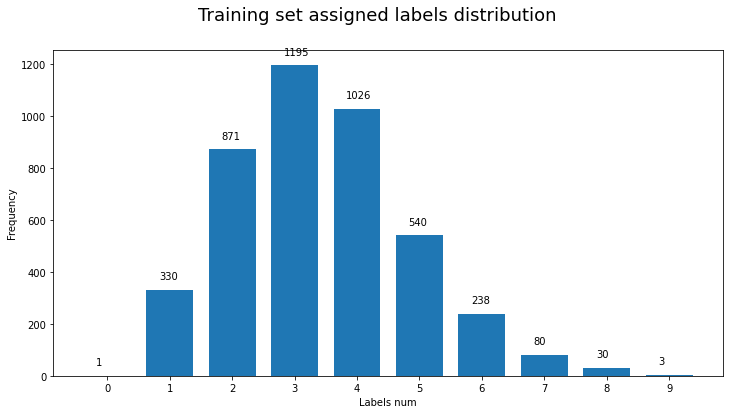

In [ ]:
labels_key = list(Counter(labels_num).keys())
labels_value = list(Counter(labels_num).values())

fig = plt.figure(figsize = (12,6))
fig.suptitle('Training set assigned labels distribution', fontsize= 18)
bars  = plt.bar(labels_key, labels_value, width = 0.75)
plt.xlabel('Labels num')
plt.ylabel('Frequency')
plt.xticks(labels_key)

# access the bar attributes to place the text in the appropriate location
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()  + 0.20, yval + 40, yval)

plt.show()

We decided to remove rows with num_labels = 0 or num_labels >= 6

In [ ]:
labels_num = np.array(labels_num)
zero_labels_indexes = np.where(labels_num == 0)
greater_six_labels_indexes = np.where(labels_num >= 7)
zero_labels_rows = df_train.iloc[zero_labels_indexes]
greater_labels_rows = df_train.iloc[greater_six_labels_indexes]

Removing the rows with zero and >= 6 labels assigned

In [ ]:
df_train.drop(zero_labels_rows.index, inplace = True)
df_train.drop(greater_labels_rows.index, inplace = True)
print(f"Len training set after removing zero assigned labels -> {len(df_train)}")

Len training set after removing zero assigned labels -> 4200


Now, we can show the labels distribution after the operations described before

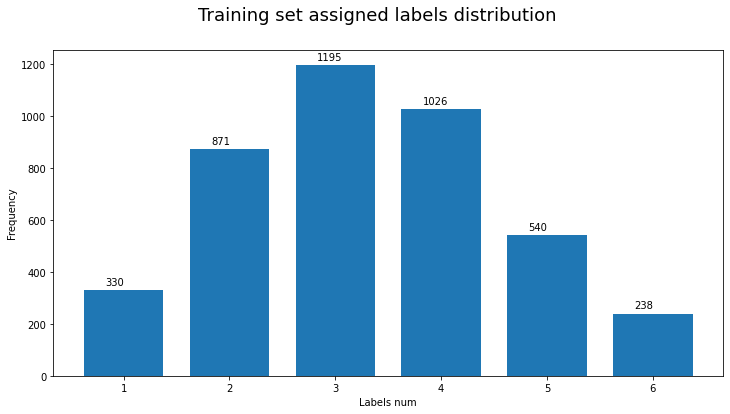

In [ ]:
labels_num = []

for labels in df_train['labels']:
  labels_num.append(np.sum(labels))

labels_key = list(Counter(labels_num).keys())
labels_value = list(Counter(labels_num).values())

fig = plt.figure(figsize = (12,6))
fig.suptitle('Training set assigned labels distribution', fontsize= 18)
bars  = plt.bar(labels_key, labels_value, width = 0.75)
plt.xlabel('Labels num')
plt.ylabel('Frequency')
plt.xticks(labels_key)

# access the bar attributes to place the text in the appropriate location
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()  + 0.20, yval + 20, yval)

plt.show()

We repeat the same operation also for the label distribution on training set

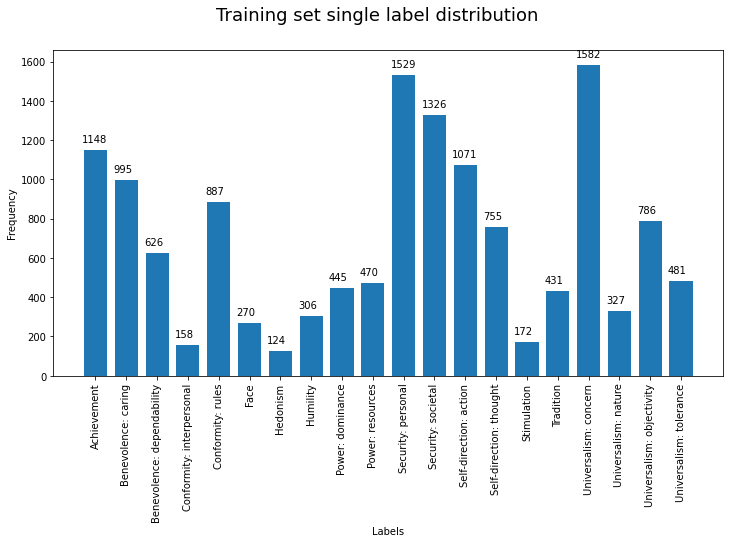

In [ ]:
all_labels = df_train['labels'].to_numpy()

decoded_labels = [decode_labels(l) for l in all_labels]
decoded_labels = list(chain(*decoded_labels))
decoded_labels = sorted(decoded_labels)

labels_key = list(Counter(decoded_labels).keys())
labels_value = list(Counter(decoded_labels).values())

fig = plt.figure(figsize = (12,6))
fig.suptitle('Training set single label distribution', fontsize= 18)
bars  = plt.bar(labels_key, labels_value, width = 0.75)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(labels_key, rotation=90)

# access the bar attributes to place the text in the appropriate location
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()  - 0.05, yval + 40, yval)

plt.show()


Also in this case, we decided to remove the labels which have a very low number of elements, which are:


1.   Hedonism
2.   Stimulation
3.   Conformity: interpersonal

In [ ]:
labels_num = []

for labels in df_train['labels']:
  if labels[LABELS_LIST.index('Hedonism')] == 1:
    labels[LABELS_LIST.index('Hedonism')] = 0

  if labels[LABELS_LIST.index('Stimulation')] == 1:
    labels[LABELS_LIST.index('Stimulation')] = 0

  if labels[LABELS_LIST.index('Conformity: interpersonal')] == 1:
    labels[LABELS_LIST.index('Conformity: interpersonal')] = 0
  
  labels_num.append(labels)

df_train['labels'] = labels_num


After removing the labels we can have a look at the new labels distribution in the training set

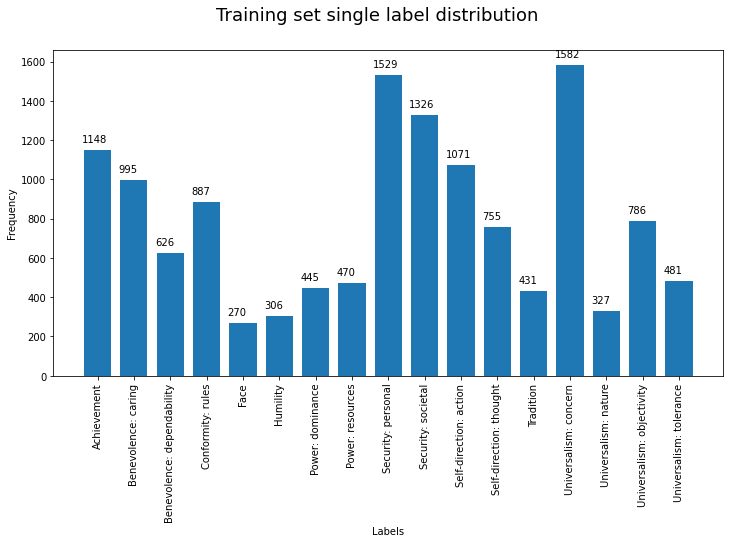

In [ ]:
all_labels = df_train['labels'].to_numpy()

decoded_labels = [decode_labels(l) for l in all_labels]
decoded_labels = list(chain(*decoded_labels))
decoded_labels = sorted(decoded_labels)

labels_key = list(Counter(decoded_labels).keys())
labels_value = list(Counter(decoded_labels).values())

fig = plt.figure(figsize = (12,6))
fig.suptitle('Training set single label distribution', fontsize= 18)
bars  = plt.bar(labels_key, labels_value, width = 0.75)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(labels_key, rotation=90)

# access the bar attributes to place the text in the appropriate location
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()  - 0.05, yval + 40, yval)

plt.show()

Lastly, we need to check and remove duplicates

In [ ]:
print(f"Len of the training set before removing duplicates: {len(df_train)}")
df_train.drop_duplicates(subset=['Conclusion', 'Premise'],inplace = True)
df_train.reset_index(inplace=True, drop=True)
print(f"Len of the training set after removing duplicates: {len(df_train)}")
df_train.head()

Len of the training set before removing duplicates: 4200
Len of the training set after removing duplicates: 4154


,Argument ID,Conclusion,Stance,Premise,labels
0,A22488,We should subsidize Wikipedia,in favor of,wikipedia provides an endless amount of inform...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,A29229,We should ban cosmetic surgery,in favor of,banning cosmetic surgery and obligatory becaus...,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."
2,A24243,We should introduce compulsory voting,against,we should not introduce compulsory voting beca...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,A12490,We should abolish the right to keep and bear arms,in favor of,the right to keep and bear arms should be abol...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."
4,A12398,We should end the use of economic sanctions,against,economic sanctions do help western countries t...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."


### Training set data augmentation

To boost the effective capacity of the network, we decided to apply some data augmentation techniques on the training set. In particular, we used [TextGenie](https://github.com/hetpandya/textgenie), a library which helps generating new samples using paraphrase generation with a generative model. <br>

The first step is the download of the T5 model for data augmentation

In [ ]:
textgenie = TextGenie('hetpandya/t5-small-tapaco')

Loading Paraphrase Model..


Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

An example of data augmentation

In [ ]:
text = df_train.loc[0]['Premise'] 
augmented_text = textgenie.magic_once(text,"paraphrase: ",paraphrase_top_k = 32, n_paraphrase_predictions=2,n_mask_predictions=None, convert_to_active=False)
print(f"Original text: {text}")

print("Augmented text:")
for idx, s in enumerate(augmented_text):
  print(f"Num: {idx+1} -> {s}")

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Original text: wikipedia provides an endless amount of information right at our fingertips.
Augmented text:
Num: 1 -> wikipedia provides an endless amount of information right at our fingertips.
Num: 2 -> wikipedia is not just an endless form of information we have to provide.
Num: 3 -> wikipedia can provide our students endless information.


We decided to paraphrase all the premises.

In [ ]:
print(f"Len of training set: {len(df_train)}")


# Since the operation of data augmentation is time consuming we decided to 
# split it in various steps (mainly due to colab usage limitations.)
# In this way, in each step are computed the operations only on 500 sentences,
# so in case of a disconnection we can restart from the point we were interrupted
saving_steps = 500
total_steps = len(df_train)//500 + 1 

print(f"total data augmentation steps: {total_steps}")
print(f"Save every {saving_steps} steps ")

last_start_row = 0
for i in range(1,total_steps):
  starting_row = (i-1) * 500
  final_row = i * 500

  print(f"Doing data augmentation from row {starting_row} to row {final_row} ")

  last_start_row = final_row

  df_tmp = df_train[starting_row:final_row]
  print(f'len: {len(df_tmp)}')
  csv_tmp_title = 'df_premises_' + str(i) +'.csv' 
  df_tmp[['Argument ID', 'Premise']].to_csv(csv_tmp_title, index=False)

  augmented_premises = textgenie.magic_lamp(csv_tmp_title,
                                            "paraphrase: ",
                                            paraphrase_top_k = 32,
                                            n_paraphrase_predictions = 2,
                                            n_mask_predictions=None,
                                            paraphrase_max_length= 256,
                                            convert_to_active=False,
                                            label_column="Argument ID",
                                            data_column="Premise")
  
  # After the operation on the 500 sentences, we save the result in a file
  augmented_premises.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/augmented_premises-' + str(i) + '.pkl')


print(f"last_start_row: {last_start_row} ")

df_tmp = df_train[last_start_row:]
print(f'len: {len(df_tmp)}')

csv_tmp_title = 'df_premises_final.csv'
df_tmp[['Argument ID', 'Premise']].to_csv(csv_tmp_title, index=False)
augmented_premises = textgenie.magic_lamp(csv_tmp_title,
                                            "paraphrase: ",
                                            paraphrase_top_k = 32,
                                            n_paraphrase_predictions = 2,
                                            n_mask_predictions=None,
                                            paraphrase_max_length= 256,
                                            convert_to_active=False,
                                            label_column="Argument ID",
                                            data_column="Premise")
  
augmented_premises.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/augmented_premises_final.pkl')

Len of training set: 4154
total data augmentation steps: 9
Save every 500 steps 
Doing data augmentation from row 0 to row 500 
len: 500


100%|██████████| 500/500 [10:04<00:00,  1.21s/it]



Completed writing output to /content/df_premises_1_aug.tsv.
Doing data augmentation from row 500 to row 1000 
len: 500


100%|██████████| 500/500 [09:13<00:00,  1.11s/it]



Completed writing output to /content/df_premises_2_aug.tsv.
Doing data augmentation from row 1000 to row 1500 
len: 500


100%|██████████| 500/500 [09:24<00:00,  1.13s/it]



Completed writing output to /content/df_premises_3_aug.tsv.
Doing data augmentation from row 1500 to row 2000 
len: 500


100%|██████████| 500/500 [09:32<00:00,  1.15s/it]



Completed writing output to /content/df_premises_4_aug.tsv.
Doing data augmentation from row 2000 to row 2500 
len: 500


100%|██████████| 500/500 [09:24<00:00,  1.13s/it]



Completed writing output to /content/df_premises_5_aug.tsv.
Doing data augmentation from row 2500 to row 3000 
len: 500


100%|██████████| 500/500 [09:02<00:00,  1.09s/it]



Completed writing output to /content/df_premises_6_aug.tsv.
Doing data augmentation from row 3000 to row 3500 
len: 500


100%|██████████| 500/500 [09:03<00:00,  1.09s/it]



Completed writing output to /content/df_premises_7_aug.tsv.
Doing data augmentation from row 3500 to row 4000 
len: 500


100%|██████████| 500/500 [09:11<00:00,  1.10s/it]



Completed writing output to /content/df_premises_8_aug.tsv.
last_start_row: 4000 
len: 154


100%|██████████| 154/154 [02:56<00:00,  1.15s/it]


Completed writing output to /content/df_premises_final_aug.tsv.


To create the final dataframe we need to join the original dataframe with the one containing the paraphrased premises. We need to make some operations since the newly created sentences have only the premises and do not have the stance and the conclusion. <br>
To solve this we need to:
1. Load all the files with the augmented premises and join them into a dataframe
2. We rename the 'Label' column in 'Argument ID' in order to do the inner join with the original training set
3. Lastly we join the datasets and remove the duplicates

In [ ]:
df_premises = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/augmented_premises-1.pkl')
for i in range(2,total_steps):
  tmp = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/augmented_premises-' + str(i) + '.pkl')
  df_premises = pd.concat([df_premises, tmp], axis=0)

tmp = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/augmented_premises_final.pkl')
df_premises = pd.concat([df_premises, tmp], axis=0)
df_premises.drop_duplicates(subset=['Text', 'Label'],inplace = True)
df_premises.reset_index(inplace=True, drop=True)

In [ ]:
df_premises = df_premises.rename(columns={"Label": "Argument ID"})
df_premises.head()

,Text,Argument ID
0,wikipedia provides endless access to information.,A22488
1,wikipedia provides an endless amount of inform...,A22488
2,wikipedia provides the endless amount of infor...,A22488
3,To avoid cosmetic surgery is unnecessary. It i...,A29229
4,banning cosmetic surgery and obligatory becaus...,A29229


In [ ]:
df_tmp = df_train.copy()
df_tmp = df_tmp.merge(df_premises, how='inner', on='Argument ID')
df_tmp.drop('Premise', inplace=True, axis=1)
df_tmp.rename(columns={"Text": "Premise"}, inplace= True)
df_tmp = df_tmp[['Argument ID','Premise','Stance','Conclusion','labels']]
df_train = df_train[['Argument ID','Premise','Stance','Conclusion','labels']]
df_train = pd.concat([df_train, df_tmp], axis=0)
df_train.drop_duplicates(subset=['Argument ID', 'Premise'],inplace = True)
df_train = shuffle(df_train)
df_train.reset_index(inplace=True, drop=True)

df_train.head()

,Argument ID,Premise,Stance,Conclusion,labels
0,A12450,Citizens should be allowed to defend themselve...,against,We should abolish the right to keep and bear arms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,A24105,We have to abolish intellectual property right...,in favor of,We should abolish intellectual property rights,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A29450,"If he received a government subsidies, journal...",against,We should subsidize journalism,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,A27181,"It's unfair for a man, who wants to come work ...",in favor of,We should end mandatory retirement,"[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,A21305,Every child has the right to be born regardles...,against,We should legalize sex selection,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df_train.shape

(12540, 5)

###Preprocessing for XGBoost

In order to do some preprocessing on the data we need to load the preprocessing tools

In [ ]:
lemmatizer = spacy.load('en_core_web_sm')
stemmer = PorterStemmer()
STOP_WORDS = set(stopwords.words('english'))

####Preprocessing functions

In [ ]:
def remove_contract(s:str) -> str:
  """
  Given a string, remove the contractions and extend the originl sentence.
  For example you're becomes you are.

  :param s: string to extend

  :return expanded_text: string containing the original text without contractions
  """
  expanded_words = []   
  for word in s.split():
    expanded_words.append(contractions.fix(word))  
  expanded_text = ' '.join(expanded_words)
  return expanded_text


def remove_punctuations(s:str) -> str:
  """
  Given a string s remove the punctuations

  :param s: original string


  :return: string which does not contain the punctuations
  """
  return s.translate(str.maketrans('', '', string.punctuation))


def remove_stopwords(s:str) -> str:
  """
  Given a string, remove the stopwords from the sentence

  :param s: Original sentence

  :return: Sentence without stopwords 
  """
  return " ".join([word for word in str(s).split() if word not in STOP_WORDS])


def lemmatize_string(s: str)-> str:
  """
  Given a sentence, lemmmatize the string

  :param s: Original sentence

  :return: Lemmatized sentence
  """
  tmp = lemmatizer(s)
  return ' '.join([token.lemma_ for token in tmp])


def stem_string(s: str)-> str:
  """
  Given a string, apply Porter stemming to the sentence

  :param s: Original sentence

  :return: Stemmed sentence  
  """
  return " ".join([stemmer.stem(word) for word in s.split()])


def to_lowercase(s:str) -> str:
  """
  Given a string, convert the string to lowercase

  :param s: Original string

  :return: Lowercase string
  """
  return s.lower()

def text_preprocessing(s : str, preprocessing_functions : List[Callable]) -> str:
  """
  Given a string and a list of preprocessing fuctions, applies all the operator
  on the given string

  :param s: original string
  :param preprocessing_functions: list of preprocessing operations which have to
  be applied to the stringW

  :return s: Original string after all the preprocessing pipeline
  """
  for func in preprocessing_functions:
    s = func(s)
  return s


An example of the chosen preprocessing pipeline, which is the following:


*   Convert the text to lowercase
*   Remove the contractions
*   Remove the punctuations
*   String normalization via lemmatization
*   Removal of the stopwords




In [ ]:
preprocessing_steps = [to_lowercase,
                       remove_contract, 
                       remove_punctuations,
                       lemmatize_string,
                       remove_stopwords]

text = '''I'll be there within 5 min. Shouldn't you be there too?
          I'd love to see u there my dear. It's awesome to meet new friends.
          We've been waiting for this day for so long.'''
print(f"Original text: {text} \n")
print(f"Preprocessed text: {text_preprocessing(text,preprocessing_steps )}")

Original text: I'll be there within 5 min. Shouldn't you be there too?
          I'd love to see u there my dear. It's awesome to meet new friends.
          We've been waiting for this day for so long. 

Preprocessed text: I within 5 min I would love see dear awesome meet new friend wait day long


Now we apply the preprocessing operations on a copy of the datasets which will be used only for one of the proposed approaches

In [ ]:
df_train_xgboost = df_train.copy()
df_val_xgboost = df_val.copy()
df_test_xgboost = df_test.copy()

#training set
tqdm.pandas()

df_train_xgboost['Conclusion'] = df_train_xgboost.progress_apply(lambda x : text_preprocessing(x['Conclusion'], preprocessing_steps ), axis=1)
df_train_xgboost['Premise'] = df_train_xgboost.progress_apply(lambda x : text_preprocessing(x['Premise'], preprocessing_steps ), axis=1)

#validation set
df_val_xgboost['Conclusion'] = df_val_xgboost.progress_apply(lambda x : text_preprocessing(x['Conclusion'], preprocessing_steps ), axis=1)
df_val_xgboost['Premise'] = df_val_xgboost.progress_apply(lambda x : text_preprocessing(x['Premise'], preprocessing_steps ), axis=1)

#test set
df_test_xgboost['Conclusion'] = df_test_xgboost.progress_apply(lambda x : text_preprocessing(x['Conclusion'], preprocessing_steps ), axis=1)
df_test_xgboost['Premise'] = df_test_xgboost.progress_apply(lambda x : text_preprocessing(x['Premise'], preprocessing_steps ), axis=1)


df_train_xgboost.drop_duplicates(subset=['Conclusion', 'Premise'],inplace = True)
df_train_xgboost.reset_index(inplace=True, drop=True)

100%|██████████| 1896/1896 [00:14<00:00, 131.45it/s]


Training set after the preprocessing

In [ ]:
df_train_xgboost.head()

,Argument ID,Premise,Stance,Conclusion,labels
0,A12450,citizen allow defend lethal force lifeordeath ...,against,abolish right keep bear arm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,A24105,abolish intellectual property right law comple...,in favor of,abolish intellectual property right,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A29450,receive government subsidy journalism would re...,against,subsidize journalism,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,A27181,unfair man want come work social security pay ...,in favor of,end mandatory retirement,"[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,A21305,every child right bear regardless gender legal...,against,legalize sex selection,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Now we save the created datasets

In [ ]:
df_train_xgboost.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_train_xgboost.pkl')
df_val_xgboost.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_val_xgboost.pkl')
df_test_xgboost.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_test_xgboost.pkl') 

###Data Analysis

After the data augmentation process we will further analyse our data in order to see how they changed and if we can obtain more useful informations.

####Training data inspection
First we start with the "Stance" column distribution which should present only two values as described in the challenge official page.

In [ ]:
print(df_train['Stance'].value_counts())

in favor of     6726
against         5767
in favour of      47
Name: Stance, dtype: int64


As we can see we have more or less the same distribution for the two classes but we have two different ways of writing "in favor of", we decided to correct this mapping the word "favour"  to "favor".

In [ ]:
df_train.loc[(df_train["Stance"] == "in favor of") | (df_train["Stance"] == "in favour of"), "Stance"] = "in favor of"
print(df_train['Stance'].value_counts())

in favor of    6773
against        5767
Name: Stance, dtype: int64


Then we decided to analyse the mean number of words for both the columns "Premises" and "Conclusions".

In [ ]:
def get_column_stats(df : pd.DataFrame, column : str):
  '''
  This function allows to compute the minimum,maximum and average number
  of words in a datframe's column

  :param df: the dataframe that will be inspected
  :param column: the name of the column considered

  :return:
    - max: the maximum number of word
    - min: the minimum number of word
    - avg: the average number of word
  '''
  number_of_words = []

  for line in df[column].to_numpy():
    number_of_words.append(len(line.split()))
  
  number_of_words = np.array(number_of_words)
  min = round(np.min(number_of_words))
  max = round(np.max(number_of_words))
  avg = round(np.mean(number_of_words))
  return min, max, avg

In [ ]:
conclusion_min, conclusion_max, conclusion_avg = get_column_stats(df_train, 'Conclusion')
premise_min, premise_max, premise_avg = get_column_stats(df_train, 'Premise')

print(f'***************Conclusion*****************')
print(f'Min number of words: {conclusion_min}')
print(f'Max number of words: {conclusion_max}')
print(f'Average number of words: {conclusion_avg}')

print(f'\n***************Premise*****************')
print(f'Min number of words: {premise_min}')
print(f'Max number of words: {premise_max}')
print(f'Average number of words: {premise_avg}')

***************Conclusion*****************
Min number of words: 4
Max number of words: 35
Average number of words: 6

***************Premise*****************
Min number of words: 3
Max number of words: 133
Average number of words: 21


Now we will plot the labels distribution on training set after data augmentation.

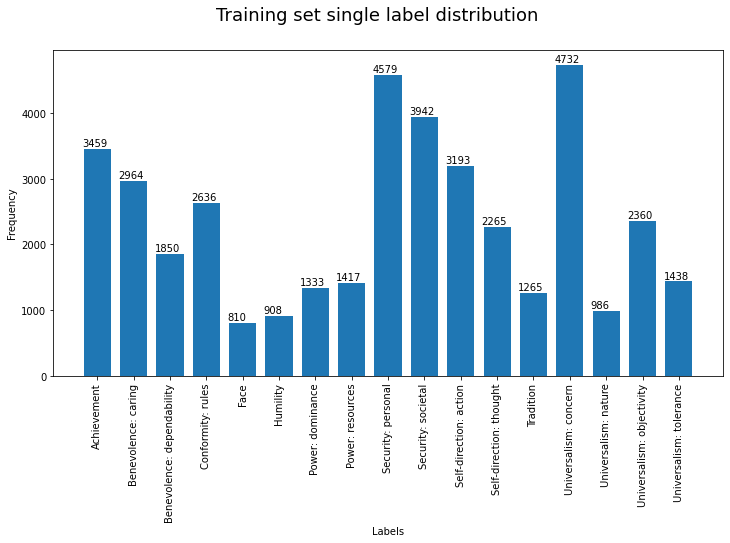

In [ ]:
all_labels = df_train['labels'].to_numpy()

decoded_labels = [decode_labels(l) for l in all_labels]
decoded_labels = list(chain(*decoded_labels))
decoded_labels = sorted(decoded_labels)

labels_key = list(Counter(decoded_labels).keys())
labels_value = list(Counter(decoded_labels).values())

fig = plt.figure(figsize = (12,6))
fig.suptitle('Training set single label distribution', fontsize= 18)
bars  = plt.bar(labels_key, labels_value, width = 0.75)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(labels_key, rotation=90)

# access the bar attributes to place the text in the appropriate location
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()  - 0.05, yval + 40, yval)

plt.show()


As we can see we preserved the original distribution.

####Validation data inspection
Again we start with the "Stance" column distribution.

In [ ]:
print(df_val['Stance'].value_counts())

in favor of     575
against         501
in favour of      3
Name: Stance, dtype: int64


We need to do the same correction as the training data case.

In [ ]:
df_val.loc[(df_val["Stance"] == "in favor of") | (df_val["Stance"] == "in favour of"), "Stance"] = "in favor of"
print(df_val['Stance'].value_counts())

in favor of    578
against        501
Name: Stance, dtype: int64


Then we analyse the mean number of words 
for both "Premises" and "Conclusions" columns.

In [ ]:
conclusion_min, conclusion_max, conclusion_avg = get_column_stats(df_val, 'Conclusion')
premise_min, premise_max, premise_avg = get_column_stats(df_val, 'Premise')

print(f'***************Conclusion*****************')
print(f'Min number of words: {conclusion_min}')
print(f'Max number of words: {conclusion_max}')
print(f'Average number of words: {conclusion_avg}')

print(f'\n***************Premise*****************')
print(f'Min number of words: {premise_min}')
print(f'Max number of words: {premise_max}')
print(f'Average number of words: {premise_avg}')

***************Conclusion*****************
Min number of words: 4
Max number of words: 26
Average number of words: 6

***************Premise*****************
Min number of words: 4
Max number of words: 126
Average number of words: 22


As we can see above we have almost the same results that we got in the training set inspection.

Now we will analyse the stats for the number of labels assigned, so we will see the minimum, the maximum and the average number of labels assigned. Moreover we will plot a bar graph to further inspect.

In [ ]:
labels_num = []

for labels in df_val['labels']:
  labels_num.append(np.sum(labels))

print(f'Min assigned labels: {min(labels_num)}')
print(f'Max assigned labels: {max(labels_num)}')
print(f'Average assigned labels: {np.round(np.mean(labels_num))}')

Min assigned labels: 1
Max assigned labels: 9
Average assigned labels: 3.0


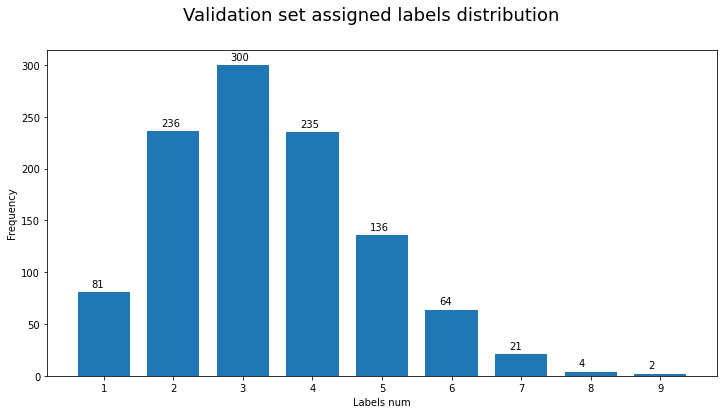

In [ ]:
labels_key = list(Counter(labels_num).keys())
labels_value = list(Counter(labels_num).values())

fig = plt.figure(figsize = (12,6))
fig.suptitle('Validation set assigned labels distribution', fontsize= 18)
bars  = plt.bar(labels_key, labels_value, width = 0.75)
plt.xlabel('Labels num')
plt.ylabel('Frequency')
plt.xticks(labels_key)

# access the bar attributes to place the text in the appropriate location
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()  + 0.20, yval + 5, yval)

plt.show()

As we can see also on the validation set there are only a few examples of cases where more than six labels are assigned.

Finally we will analyse the labels distribution plotting a bar graph.

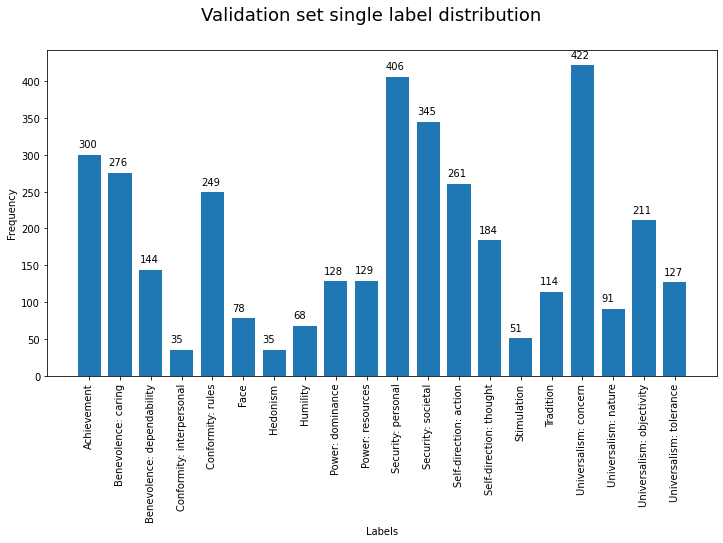

In [ ]:
all_labels = df_val['labels'].to_numpy()

decoded_labels = [decode_labels(l) for l in all_labels]
decoded_labels = list(chain(*decoded_labels))
decoded_labels = sorted(decoded_labels)

labels_key = list(Counter(decoded_labels).keys())
labels_value = list(Counter(decoded_labels).values())

fig = plt.figure(figsize = (12,6))
fig.suptitle('Validation set single label distribution', fontsize= 18)
bars  = plt.bar(labels_key, labels_value, width = 0.75)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(labels_key, rotation=90)

# access the bar attributes to place the text in the appropriate location
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()  + 0.005, yval + 10, yval)

plt.show()


As we can see in the graph above the distribution is the same as the one seen for the training set.

###Save dataframe to Google Drive

Since the data augmentation and the preprocessing phase took a discrete amount of computational time we decided to save to processed dataset to Google Drive.

Before saving the datasets, we check the test set for "Stance" column spelling errors as well and replace them.

In [ ]:
df_test.loc[(df_test["Stance"] == "in favor of") | (df_test["Stance"] == "in favour of"), "Stance"] = "in favor of"
print(df_test['Stance'].value_counts())

in favor of    1058
against         838
Name: Stance, dtype: int64


In [ ]:
df_train.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_train.pkl')
df_val.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_val.pkl')
df_test.to_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_test.pkl') 

## Restore dataframes

In this section we just restore the previously stored dataset in order to save time.

In [ ]:
df_train = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_train.pkl')
df_val = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_val.pkl')
df_test = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_test.pkl')

df_train_xgboost = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_train_xgboost.pkl')
df_val_xgboost = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_val_xgboost.pkl')
df_test_xgboost = pd.read_pickle(PROJECT_WORK_LOCAL_PATH+'/dataframe/df_test_xgboost.pkl')

print('Dataset splits statistics: ')
print(f'Train data shape: {df_train.shape}')
print(f'Validation data shape: {df_val.shape}')
print(f'Test data shape: {df_test.shape}')

Dataset splits statistics: 
Train data shape: (12537, 5)
Validation data shape: (1079, 5)
Test data shape: (1896, 5)


Some example of training data after restoring

In [ ]:
df_train.head()

,Argument ID,Premise,Stance,Conclusion,labels
0,E02053,There should be more time spent in keeping the...,in favor of,The European Union should support and integrat...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
1,A30338,"Libertarianism is cruel and short-sighted, and...",against,We should adopt libertarianism,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,A23410,nuclear weapons are important in the fight aga...,against,We should fight for the abolition of nuclear w...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,D27038,Many false domestic violence cases are being r...,in favor of,Men are silent sufferers in this modern world,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,A30319,Many television shows and films play child rol...,against,We should ban the use of child actors,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## XGBoost
The first approach we propose consists into using an ensemble method, known as XGBoost to assign the labels to the data. <br>

This techinque uses Gradient boosting, which consists of using an ensemble of weak classifiers, in our case an ensemble of tree models, to make a prediction. We decided to use this particular machine learning based architecture because it is currently used in some multi-label classification task and it is a good baseline model.

In [ ]:
def transform_y(train_labels: pandas.core.series.Series, 
                val_labels: pandas.core.series.Series,
                test_labels: pandas.core.series.Series):
    """
    The function converts the labels for the training, validation and test sets
    binarizing them with a MultiLabelBinarizer. It produces then the binarized 
    versions of the arrays.

    :param train_labels: Series containing all the ground truths for the training set
    :param val_labels: Series containing all the ground truths for the validation set
    :param test_labels: Series containing all the ground truths for the test set


    :return: Binarized version of the labels for each set
    """
    train_labels = train_labels.apply(lambda x: [i for i, x in enumerate(x) if x == 1])
    val_labels = val_labels.apply(lambda x: [i for i, x in enumerate(x) if x == 1])
    test_labels = test_labels.apply(lambda x: [i for i, x in enumerate(x) if x == 1])

    mlb = MultiLabelBinarizer()
    mlb.fit(train_labels)

    mlb_train = mlb.transform(train_labels)
    mlb_val = mlb.transform(val_labels)
    mlb_test = mlb.transform(test_labels)


    return mlb_train, mlb_val, mlb_test, mlb


def train_pipeline(X_train, y_train):
    """
    The method allows to create and train a machine learning pipeline made of 
    two steps, given the training data. In the first step of the pipeline there
    is a vectorizer which converts the documents into their tf-idf vectors and 
    then the document vector is fed into the boosting model.

    :param  X_train: training arguments
    :praam  y_train: training labels
    """
    xgb = Pipeline([
        ('tfidf', TfidfVectorizer(
            min_df=0.1,
            ngram_range=(1, 1),
            use_idf=1,
            smooth_idf=1,
            sublinear_tf=1)),
        ('clf', LabelPowerset(
            XGBRFClassifier(       
                random_state=42,
                n_jobs=-1,
                max_depth=7,
                n_estimators=65,
                )
            ))
    ])

    xgb.fit(X_train, y_train)
    print("Finished training")

    return xgb

In [ ]:
x_train = df_train_xgboost['Premise'].apply(lambda x : x  + ' ')   + df_train_xgboost['Stance'].apply(lambda x : x  + ' ') + df_train_xgboost['Conclusion']
x_val = df_val_xgboost['Premise'].apply(lambda x : x  + ' ')   + df_val_xgboost['Stance'].apply(lambda x : x  + ' ') + df_val_xgboost['Conclusion']
x_test = df_test_xgboost['Premise'].apply(lambda x : x  + ' ')   + df_test_xgboost['Stance'].apply(lambda x : x  + ' ') + df_test_xgboost['Conclusion']

y_train, y_val, y_test, mlb = transform_y(df_train_xgboost['labels'], df_val_xgboost['labels'], df_test_xgboost['labels'])

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:875: UserWarning: unknown class(es) [12, 2, 3] will be ignored
  warnings.warn(


In [ ]:
model = train_pipeline(x_train,y_train)

Finished training


After fitting the model to the training data we test it and compute the f1 scores of the model.

In [ ]:
res = model.predict(x_test)

In [ ]:
y_pred = []
for i in range(len(y_test)):
  y_pred.append(res[i].toarray()[0])

averaging_techniques = [ 'micro', 'macro', 'samples', 'weighted']

for avg in averaging_techniques:
  precision = precision_score(y_test,y_pred, average=avg, zero_division=1)
  recall = recall_score(y_test,y_pred,average=avg,zero_division=1)
  f1 = f1_score(y_test,y_pred,average=avg,zero_division=1)

  print('--------------------------- {} ------------------'.format(avg))
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1: ", f1)
  print()

--------------------------- micro ------------------
Precision:  0.3294050014371946
Recall:  0.18917134367778143
F1:  0.24032714690154133

--------------------------- macro ------------------
Precision:  0.6914832165611914
Recall:  0.12345642736967602
F1:  0.10395006573966227

--------------------------- samples ------------------
Precision:  0.32832278481012656
Recall:  0.19765358147478398
F1:  0.23355769874757218

--------------------------- weighted ------------------
Precision:  0.6282245132254105
Recall:  0.18917134367778143
F1:  0.16195018943081915



In [ ]:
print(classification_report(y_test,y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.15      0.17      0.16       251
           1       0.41      0.36      0.39       496
           2       1.00      0.00      0.00       575
           3       1.00      0.00      0.00       164
           4       1.00      0.00      0.00       132
           5       1.00      0.00      0.00       130
           6       0.49      0.22      0.30       759
           7       0.30      0.70      0.42       488
           8       1.00      0.00      0.00       172
           9       0.00      0.00      0.00       455
          10       1.00      0.00      0.00       127
          11       1.00      0.00      0.00       633
          12       1.00      0.00      0.00       268
          13       0.36      0.60      0.45       687
          14       0.05      0.06      0.05       127
          15       1.00      0.00      0.00       223
          16       1.00      0.00      0.00       371

   micro avg       0.33   

## Transformers
Transformer architecture was introduced by Google in 2017, since then thanks to the self-attention mechanism, which allows to process the entire input as a single sequence, they have replaced recurrent neural networks (RNN) in many Natural Language Processing (NLP) and Computer Vision (CV) tasks.
In particular, thanks to the self-attention mechanism Transformers can be trained on larger datasets using the additional parallelization. This has led to the creation of pre-trained systems such as BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer).
In this work, we will try to solve the multi-label classification problem using three different architectures based on Transformers:
- BERT-base
- roBERTA-base
- XLNet


### Common functions
In this section, we will collect all the common functions used to train and evaluate the three models

#### Output decoding
In order to decode the output of the models we need a function that maps back the one-hot encode of the labels

In [ ]:
LABELS_LIST = ["Self-direction: thought",
               "Self-direction: action", 
               "Stimulation",
               "Hedonism",
               "Achievement",
               "Power: dominance", 
               "Power: resources",
               "Face",
               "Security: personal",
               "Security: societal",
               "Tradition", 
               "Conformity: rules",
               "Conformity: interpersonal",
               "Humility",
               "Benevolence: caring",
               "Benevolence: dependability", 
               "Universalism: concern", 
               "Universalism: nature",
               "Universalism: tolerance",
               "Universalism: objectivity"]

def decode_labels(labels_array : List[int]) -> List[str]:
  """
  Function which allows to obtain the list of the labels, given the one hot 
  encoding. In case of a multi-label problem the list can have more than one
  element.

  :param labels_array: List containing the one-hot encoding we want to decode

  :return classes_label: List containing the classes of the given one hot encoded
  labels
  """
  class_indexes = np.where(labels_array != 0)[0]
  classes_labels = []

  for idx in class_indexes:
    classes_labels.append(LABELS_LIST[idx])

  return classes_labels

#### Custom loss function: DBloss
To improve our models with respect to the class imbalance present in the dataset we have tried various loss functions, in particular in addition to the Binary Cross Entropy (BCE), which is the standard loss used for multi-label classification, we have found in the literature the
[Distribution Balanced Loss 
(DBloss)](https://arxiv.org/pdf/2109.04712v2.pdf). \\


To use the latter we need to download and import the implementation from github

In [ ]:
!wget https://raw.githubusercontent.com/Roche/BalancedLossNLP/main/Reuters/util_loss.py
from util_loss import ResampleLoss

--2023-01-06 18:29:07--  https://raw.githubusercontent.com/Roche/BalancedLossNLP/main/Reuters/util_loss.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9801 (9.6K) [text/plain]
Saving to: ‘util_loss.py.1’

util_loss.py.1      100%[===================>]   9.57K  --.-KB/s    in 0s      

2023-01-06 18:29:07 (71.6 MB/s) - ‘util_loss.py.1’ saved [9801/9801]



We need to compute the following parameters used by DBloss implementation:
- *train_num,* i.e. simply the length of the training set;
- *class_freq*, i.e. occurrence counter for each label.

In [ ]:
all_labels = df_train['labels'].to_numpy()

class_freq = {}

decoded_labels = [decode_labels(l) for l in all_labels]
decoded_labels = list(chain(*decoded_labels))

for label in LABELS_LIST:
  class_freq.update({label : decoded_labels.count(label)})

train_num = len(df_train)
print(class_freq)

{'Self-direction: thought': 2264, 'Self-direction: action': 3196, 'Stimulation': 0, 'Hedonism': 0, 'Achievement': 3461, 'Power: dominance': 1339, 'Power: resources': 1414, 'Face': 812, 'Security: personal': 4571, 'Security: societal': 3943, 'Tradition': 1262, 'Conformity: rules': 2627, 'Conformity: interpersonal': 0, 'Humility': 903, 'Benevolence: caring': 2960, 'Benevolence: dependability': 1846, 'Universalism: concern': 4730, 'Universalism: nature': 988, 'Universalism: tolerance': 1444, 'Universalism: objectivity': 2354}


####Defining Multi-label classifier base class
To test different loss functions we need to override the *Forward* method of Hugginface's *AutoModelForSequenceClassification* class, so we will define a custom class specifically for multi-label classification and allowing to switch between different loss in the *Forward* method

In [ ]:
#Default loss used
LOSS_NAME='BCE'

class AutoModelMultilabelSequenceClassification(AutoModelForSequenceClassification):
  
    def __init__(self, config):
      super().__init__(config)

    def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict)

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            
            
            if LOSS_NAME == 'DBloss':
              loss_fct = ResampleLoss(reweight_func='rebalance', loss_weight=1.0,
                                focal=dict(focal=True, alpha=0.5, gamma=2),
                                logit_reg=dict(init_bias=0.05, neg_scale=2.0),
                                map_param=dict(alpha=0.1, beta=10.0, gamma=0.25), 
                                class_freq=class_freq, train_num=train_num)
            else:
              loss_fct = torch.nn.BCEWithLogitsLoss()

            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))
            

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions)

#### Load the models and tokenizers


We define a function used to load and configure models and tokenizers.

In [ ]:
def get_model_and_tokenizer(petrained_model_name : str):
  """
  Loads and configure a pretrained model via HuggingFace transformers library with the corresponding tokenizer.

  :param petrained_model_name: name of the model to load

  :return:
    - model: pretrained  transformer model
    - tokenizer: model corresponding tokenizer

  """
  id2label = {}
  label2id = {}

  for idx, label in enumerate(LABELS_LIST):
      id2label[idx] = label
      label2id[label] = idx

  model = AutoModelMultilabelSequenceClassification.from_pretrained(
                    petrained_model_name,
                    num_labels=len(LABELS_LIST),
                    id2label= id2label, 
                    label2id =label2id).to(device)

  tokenizer = AutoTokenizer.from_pretrained(petrained_model_name)

  model.config.early_stopping = True
  model.config.cls_token_id = tokenizer.cls_token_id
  model.config.eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id
  

  return model, tokenizer

#### Dataset Tokenization
Before we can actually start the training process we need some functions to tokenize our datasets. For compatibility reason we will use the Huggingface dataset type from the Datasets library.

In [ ]:
def process_data_to_model_inputs(batch, tokenizer):
  '''
  This function allows to tokenize a batch of data

  :param batch: the batch of data that will be tokenized
  :param tokenizer: the model tokenizer that will be used to tokenize the batch

  :return batch: batch of data tokenized
  '''
  INPUT_MAX_LENGTH = 128
  input = []
  for conclusion, stance, premise in zip(batch["Conclusion"], batch["Stance"], batch["Premise"]):
    input.append(premise +' '+ tokenizer.sep_token + ' this is ' + stance + ' ' + conclusion)

  inputs = tokenizer(input,
                     padding="max_length",
                     truncation="longest_first",
                     max_length=INPUT_MAX_LENGTH)
  

  
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  return batch

In [ ]:
def tokenize_dataset(df : pd.DataFrame, tokenizer):
  '''
  This function allows to tokenize an entire dataset

  :param df: the dataframe that will be tokenized
  :param tokenizer: the model tokenizer that will be used to tokenize the dataset

  :return df_tokenized: dataset tokenized
  '''
  
  df_tokenized = datasets.Dataset.from_pandas(df)
  old_column_names = (list(df_tokenized.features.keys()))
  old_column_names.remove('labels')

  df_tokenized = df_tokenized.map(
    process_data_to_model_inputs, 
    fn_kwargs={ "tokenizer": tokenizer},
    batched=True, 
    batch_size=BATCH_SIZE, 
    remove_columns=old_column_names
  )
  df_tokenized = df_tokenized.cast_column("labels", Sequence(Value("float32")))
  df_tokenized.set_format(type="torch", device = device, columns=["input_ids", "attention_mask", "labels"])
  return df_tokenized

#### Define the Metric function
To evaluate our results we will use the F1 score, commonly used in text classification tasks, and the Area Under the Receiver Operating Characteristic Curve (ROC AUC) score adjusted for multi-label problems.

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    '''
    Utility function used to calculate the F1 score and ROC AUC score for multi-label tasks.
    Specifically, this function will use the sigmoid to convert from logit to probability and 
    then apply a threshold to convert to a binary array. Finally, the metric can be calculated.

    :param predictions: predicted logits from the model
    :param labels: ground-truth values
    :param threshold: the threshold applied to convert from probability to binary array

    :return a dictionary containing the computed F1 score and ROC AUC score
    '''
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    # return as dictionary
    metrics = {'macro f1': f1_macro_average,
               'roc_auc': roc_auc}
    return metrics

def compute_metrics(p: EvalPrediction):
    '''
    This function allows to compute the F1 score value  and the ROC AUC score for a batch of predictions

    :param EvalPrediction: the predicted labels

    :return a dictionary containing the computed F1 score and ROC AUC score for the entire batch 
    '''
    preds = p.predictions[0] if isinstance(p.predictions,tuple) else p.predictions
    result = multi_label_metrics(predictions=preds,labels=p.label_ids)
    return result

####Defining the Training Function
To train our model we will use the *Trainer API* from Huggingface.
The Trainer class provides an API for feature-complete training in PyTorch for 
most standard use cases. So, the Trainer class is a simple but feature-complete training and eval loop for PyTorch, optimized for Huggingface Transformers. \\
In this section we will define two utility functions used to get the Trainer and to start training a model.

In [ ]:
def get_trainer(model,tokenizer, training_args, df_train, df_val):
  '''
  This function allows to get a Trainer object that will be used
  to train our models

  :param model: the model that will be trained
  :param tokenizer: the model tokenizer
  :param training_args: TrainingArguments object that contains the trainer settings
  :param df_train: the dataset used for the training phase
  :param df_val: the dataset used fot the validation phase

  :return Trainer object
  '''
  trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer= tokenizer,
    train_dataset=df_train,
    eval_dataset=df_val,
  )
  return trainer


In [ ]:
def train_model(model, tokenizer, training_args, df_train, df_val, save_path, resume_from_checkpoint = False ):
  '''
  This function allows to start or resume the model training, after the training it saves the model

  :param model: the model that will be trained
  :param tokenizer: the model tokenizer
  :param training_args: TrainingArguments that contains the trainer settings
  :param df_train: the dataset used for the training phase
  :param df_val: the dataset used fot the validation phase
  :param save_path: the path where the model will be saved
  :param resume_from_checkpoint: a boolean that checks if the training will restart from a checkpoint
  '''

  trainer = get_trainer(model, tokenizer, training_args, df_train, df_val)
  print('*********sanity check that we can run evaluation***********')
  trainer.evaluate()
  print('************ TRAINING START ************')
  trainer.train(resume_from_checkpoint = resume_from_checkpoint)
  trainer.save_model(save_path)
  print('********** TRAINING END *************')
  return 

#### Model evaluation functions
After we have completed the training phase we need to evaluate our models on the test set, so we will define some function in order to speed up our evaluations.

In [ ]:
def generate_predictions_for_evaluation(batch, model, tokenizer, treshold):
  '''
  This function allows to generate classification predictions for a batch of inputs

  :param batch: the batch of input data
  :param model: the model that will be used to classify
  :param tokenizer: the model tokenizer
  :param threshold: the threshold applied to convert from probability to binary array


  :return batch: the batch extended with the predicted labels as binary array and the corresponding probability as float
  '''
  outputs = model(batch['input_ids'],attention_mask=batch['attention_mask']).logits.tolist()

  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(outputs))
  

  pred_labels = np.where(np.array(probs) > treshold, 1, 0)
  
  batch["predictions"] = pred_labels
  batch["probabilities"] = probs
  return batch


def compute_evaluation_metrics(model, tokenizer, df_test,treshold = 0.5, verbose = True):
    '''
    This function allows to compute the Precision, the Tecall and the F1 score
    for each single label and their Micro, Macro, Samples and Weighted average
    using the sklearn classification_report implementation


    :param model: the model that will be used to classify
    :param tokenizer: the model tokenizer
    :param df_test: the test set used for evaluation
    :param threshold: the threshold applied to convert from probability to binary array
    :param verbose: if true print the sklearn classification report

    :return 
      - metrics: the computed metrics as dictionary
      - model_results: Huggingface Dataset object containing the predictions as binary array and the corresponding probability 
    '''
    model_results = df_test.map(generate_predictions_for_evaluation,
                             fn_kwargs={ "model": model,"tokenizer": tokenizer, "treshold" : treshold},
                             batched=True,
                             batch_size=BATCH_SIZE,
                             remove_columns=['input_ids', 'attention_mask']
                             )

    predictions = model_results['predictions'].cpu().data.numpy()
    y_true = model_results['labels'].cpu().data.numpy()

    if verbose:                                                  
      print(sklearn.metrics.classification_report(y_true,predictions, zero_division =1))

    metrics = sklearn.metrics.classification_report(y_true,predictions, output_dict = True,  zero_division =1)

    return metrics, model_results


### Model 1: BERT base uncased
Our first tested model will be BERT-base-uncased


#### Model Training
After some tests we found the following as the best parameter to train this model:
- batch size = 64
- learning rates = 5e-5
- loss = DB
- epochs = 3

Now we can train our model.


In [ ]:
BATCH_SIZE = 64
model_name = 'bert-base-uncased'
training_checkpoint_path = PROJECT_WORK_LOCAL_PATH + "/checkpoint/" + model_name
save_model_path = PROJECT_WORK_LOCAL_PATH + "/trained_model/" + model_name

LOSS_NAME = 'DBloss'
#LOSS_NAME = 'BCE'

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True, 
    logging_steps= len(df_train) // BATCH_SIZE,
    output_dir = training_checkpoint_path,
    optim='adamw_torch',
    report_to ='all',
)

print('Loading the model and tokenizer')
model, tokenizer = get_model_and_tokenizer(model_name)
print(f'Model {model_name} downloaded')

print('************ DATASETS TOKENIZATION *******')
df_train_tokenized = tokenize_dataset(df_train, tokenizer)
df_val_tokenized = tokenize_dataset(df_val, tokenizer)

train_model(model, 
            tokenizer,
            training_args,
            df_train_tokenized, 
            df_val_tokenized, 
            save_path = save_model_path,
            resume_from_checkpoint = False
            )


del model
torch.cuda.empty_cache()

PyTorch: setting up devices


Loading the model and tokenizer


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Self-direction: thought",
    "1": "Self-direction: action",
    "2": "Stimulation",
    "3": "Hedonism",
    "4": "Achievement",
    "5": "Power: dominance",
    "6": "Power: resources",
    "7": "Face",
    "8": "Security: personal",
    "9": "Security: societal",
    "10": "Tradition",
    "11": "Conformity: rules",
    "12": "Conformity: interpersonal",
    "13": "Humility",
    "14": "Benevolence: caring",
    "15": "Benevolence: dependability",
    "16": "Universalism: concern",
    "17": "Universa

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

Model bert-base-uncased downloaded
************ DATASETS TOKENIZATION *******


  0%|          | 0/196 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Using cuda_amp half precision backend
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


*********sanity check that we can run evaluation***********


***** Running training *****
  Num examples = 12540
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 784
  Number of trainable parameters = 109497620


************ TRAINING START ************


Epoch,Training Loss,Validation Loss,Macro f1,Roc Auc
1,0.365200,0.340221,0.244525,0.583736
2,0.271300,0.321674,0.349005,0.624533
3,0.221600,0.323271,0.396956,0.644597
4,0.192200,0.325463,0.397676,0.645184


***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/bert-base-uncased
Configuration saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/bert-base-uncased/config.json
Model weights saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/bert-base-uncased/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/bert-base-uncased/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/bert-base-uncased/special_tokens_map.json


********** TRAINING END *************


#### Model Evaluation
For the model evaluation phase we decided to exploit two different technique of thresholding:

- **Global Thresholding** which uses a single threshold for all the labels;
- **Individual Thresholding** which uses a different threshold value for each label.

First of all we load the tokenizer and our model from the drive.

In [ ]:
BATCH_SIZE = 64
model_name = 'bert-base-uncased'
save_model_path = PROJECT_WORK_LOCAL_PATH + "/trained_model/" + model_name

model = AutoModelMultilabelSequenceClassification.from_pretrained(save_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/bert-base-uncased/config.json
Model config BertConfig {
  "_name_or_path": "/content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token_id": 101,
  "early_stopping": true,
  "eos_token_id": 102,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Self-direction: thought",
    "1": "Self-direction: action",
    "2": "Stimulation",
    "3": "Hedonism",
    "4": "Achievement",
    "5": "Power: dominance",
    "6": "Power: resources",
    "7": "Face",
    "8": "Security: personal",
    "9": "Security: societal",
    "10": "Tradition",
    "11": "Conformity: rules",
    "12": "Conformity: interpersonal",
    "13": "Humility",
    "14": "Benevolence: caring",
  

#####Global Threshold

For the global threshold technique we decided to use a generic 0.5 value for our threshold, in the following table the obtained results. 

In [ ]:
print('************ Test set tokenization*******')
df_test_tokenized = tokenize_dataset(df_test, tokenizer)
model1_metrics, df_with_results = compute_evaluation_metrics(model,tokenizer,df_test_tokenized, treshold = 0.5 )

************ Test set tokenization*******


  0%|          | 0/30 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

              precision    recall  f1-score   support

           0       0.61      0.39      0.48       251
           1       0.62      0.45      0.53       496
           2       1.00      0.00      0.00       138
           3       1.00      0.00      0.00       103
           4       0.72      0.55      0.63       575
           5       0.65      0.07      0.12       164
           6       0.51      0.32      0.39       132
           7       1.00      0.00      0.00       130
           8       0.73      0.74      0.74       759
           9       0.65      0.55      0.59       488
          10       0.65      0.30      0.41       172
          11       0.60      0.33      0.43       455
          12       1.00      0.00      0.00        60
          13       0.00      0.00      0.00       127
          14       0.63      0.43      0.51       633
          15       0.38      0.02      0.04       268
          16       0.71      0.58      0.64       687
          17       0.76    

##### Individual Treshold

To compute the individual threshold for each label we pick the values that maximize each f1 score, obviously all the computation are made on the train set.

In [ ]:
df_train_val= pd.concat([df_train, df_val], axis=0)
df_train_val_tokenized = tokenize_dataset(df_train_val, tokenizer)

_, df_train_val_results = compute_evaluation_metrics(model,tokenizer,df_train_val_tokenized, treshold = 0.5, verbose = False )

probabilities = df_train_val_results['probabilities'].cpu().data.numpy()
labels = df_train_val_results['labels'].cpu().data.numpy()

tresholds = np.linspace(0.01, 0.5, 50)
best_tresholds = {}

idx = 0
for probabilities, labels in zip(probabilities.T, labels.T):
  f1_scores = []
  for treshold in tresholds:
    pred_labels = np.where(probabilities > treshold, 1, 0)
    f1_scores.append(f1_score(y_true=labels, y_pred=pred_labels))

  best_tresholds.update({ LABELS_LIST[idx] : tresholds[np.argmax(f1_scores)]})
  idx +=1

print('Best individual tresholds founded:')
best_tresholds  

  0%|          | 0/213 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/213 [00:00<?, ?ba/s]

Best individual tresholds founded:


{'Self-direction: thought': 0.41000000000000003,
 'Self-direction: action': 0.37,
 'Stimulation': 0.02,
 'Hedonism': 0.01,
 'Achievement': 0.46,
 'Power: dominance': 0.24000000000000002,
 'Power: resources': 0.37,
 'Face': 0.15000000000000002,
 'Security: personal': 0.45,
 'Security: societal': 0.48000000000000004,
 'Tradition': 0.29000000000000004,
 'Conformity: rules': 0.37,
 'Conformity: interpersonal': 0.03,
 'Humility': 0.18000000000000002,
 'Benevolence: caring': 0.37,
 'Benevolence: dependability': 0.24000000000000002,
 'Universalism: concern': 0.44,
 'Universalism: nature': 0.31,
 'Universalism: tolerance': 0.27,
 'Universalism: objectivity': 0.29000000000000004}

After computing the individual tresholds for each label, we can evaluate our model, the results are in the following table.

In [ ]:
probabilities = df_with_results['probabilities'].cpu().data.numpy()
labels = df_with_results['labels'].cpu().data.numpy()

for i, prob in enumerate(probabilities):
  for j, p in enumerate(prob):
    probabilities[i][j] = np.where(probabilities[i][j] > best_tresholds[LABELS_LIST[j]], 1, 0)

print(sklearn.metrics.classification_report(labels,probabilities))


              precision    recall  f1-score   support

           0       0.52      0.47      0.50       251
           1       0.55      0.53      0.54       496
           2       0.05      0.09      0.07       138
           3       0.03      0.24      0.06       103
           4       0.70      0.57      0.63       575
           5       0.30      0.18      0.23       164
           6       0.41      0.40      0.41       132
           7       0.19      0.15      0.17       130
           8       0.72      0.77      0.74       759
           9       0.64      0.56      0.60       488
          10       0.54      0.39      0.45       172
          11       0.55      0.42      0.48       455
          12       0.03      0.02      0.02        60
          13       0.13      0.03      0.05       127
          14       0.56      0.59      0.57       633
          15       0.25      0.33      0.29       268
          16       0.68      0.62      0.65       687
          17       0.72    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 2: RoBERTa Base
Our second tested model will be Roberta Base

#### Model Training
After some tests we found the following as the best parameter to train this model:
- batch size = 32
- learning rates = 2e-5
- loss = BCE
- epochs = 4

Now we can train our model.


In [ ]:
BATCH_SIZE = 32
model_name = 'roberta-base'
training_checkpoint_path = PROJECT_WORK_LOCAL_PATH + "/checkpoint/" + model_name
save_model_path = PROJECT_WORK_LOCAL_PATH + "/trained_model/" + model_name

#LOSS_NAME = 'DBloss'
LOSS_NAME = 'BCE'

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=False, 
    logging_steps= len(df_train) // BATCH_SIZE,
    output_dir = training_checkpoint_path,
    optim='adamw_torch',
    report_to ='all',
    lr_scheduler_type ='cosine'
)

print('Loading the model and tokenizer')
model, tokenizer = get_model_and_tokenizer(model_name)
print(f'Model {model_name} downloaded')

print('************ DATASETS TOKENIZATION *******')
df_train_tokenized = tokenize_dataset(df_train, tokenizer)
df_val_tokenized = tokenize_dataset(df_val, tokenizer)

train_model(model, 
            tokenizer,
            training_args,
            df_train_tokenized, 
            df_val_tokenized, 
            save_path = save_model_path,
            resume_from_checkpoint = False
            )


del model
torch.cuda.empty_cache()

Loading the model and tokenizer


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model roberta-base downloaded
************ DATASETS TOKENIZATION *******


  0%|          | 0/392 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

***** Running Evaluation *****
  Num examples = 1079
  Batch size = 32
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


*********sanity check that we can run evaluation***********


***** Running training *****
  Num examples = 12540
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1568
  Number of trainable parameters = 124661012


************ TRAINING START ************


Epoch,Training Loss,Validation Loss,Macro f1,Roc Auc
1,0.359300,0.329235,0.298132,0.603538
2,0.271900,0.312859,0.376307,0.635306
3,0.236300,0.308415,0.411883,0.651725
4,0.220600,0.308365,0.416046,0.653602


***** Running Evaluation *****
  Num examples = 1079
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base
Configuration saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base/config.json
Model weights saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base/special_tokens_map.json


********** TRAINING END *************


#### Model Evaluation


In [ ]:
BATCH_SIZE = 32
model_name = 'roberta-base'
save_model_path = PROJECT_WORK_LOCAL_PATH + "/trained_model/" + model_name

model = AutoModelMultilabelSequenceClassification.from_pretrained(save_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "cls_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Self-direction: thought",
    "1": "Self-direction: action",
    "2": "Stimulation",
    "3": "Hedonism",
    "4": "Achievement",
    "5": "Power: dominance",
    "6": "Power: resources",
    "7": "Face",
    "8": "Security: personal",
    "9": "Security: societal",
    "10": "Tradition",
    "11": "Conformity: rules",
    "12": "Conformity: interpersonal",
    "13": "Humility",
    "14": "Benevolence: caring",
    "15": "Benevolence: 

#####Global Threshold

In [ ]:
print('************ Test set tokenization*******')
df_test_tokenized = tokenize_dataset(df_test, tokenizer)
model1_metrics, df_with_results = compute_evaluation_metrics(model,tokenizer,df_test_tokenized, treshold = 0.5 )

************ Test set tokenization*******


  0%|          | 0/60 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/60 [00:00<?, ?ba/s]

              precision    recall  f1-score   support

           0       0.56      0.41      0.48       251
           1       0.69      0.43      0.53       496
           2       1.00      0.00      0.00       138
           3       1.00      0.00      0.00       103
           4       0.75      0.53      0.62       575
           5       0.65      0.08      0.14       164
           6       0.44      0.26      0.33       132
           7       1.00      0.00      0.00       130
           8       0.72      0.77      0.74       759
           9       0.70      0.59      0.64       488
          10       0.68      0.31      0.43       172
          11       0.64      0.40      0.49       455
          12       1.00      0.00      0.00        60
          13       0.15      0.02      0.04       127
          14       0.70      0.44      0.54       633
          15       0.50      0.06      0.11       268
          16       0.71      0.64      0.67       687
          17       0.80    

##### Individual Treshold

In [ ]:
df_train_val= pd.concat([df_train, df_val], axis=0)
df_train_val_tokenized = tokenize_dataset(df_train_val, tokenizer)

_, df_train_val_results = compute_evaluation_metrics(model,tokenizer,df_train_val_tokenized, treshold = 0.5, verbose = False )

probabilities = df_train_val_results['probabilities'].cpu().data.numpy()
labels = df_train_val_results['labels'].cpu().data.numpy()

tresholds = np.linspace(0.01, 0.5, 50)
best_tresholds = {}

idx = 0
for probabilities, labels in zip(probabilities.T, labels.T):
  f1_scores = []
  for treshold in tresholds:
    pred_labels = np.where(probabilities > treshold, 1, 0)
    f1_scores.append(f1_score(y_true=labels, y_pred=pred_labels))

  best_tresholds.update({ LABELS_LIST[idx] : tresholds[np.argmax(f1_scores)]})
  idx +=1

print('Best individual tresholds founded:')
best_tresholds  

  0%|          | 0/426 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/426 [00:00<?, ?ba/s]

Best individual tresholds founded:


{'Self-direction: thought': 0.42000000000000004,
 'Self-direction: action': 0.35000000000000003,
 'Stimulation': 0.01,
 'Hedonism': 0.01,
 'Achievement': 0.4,
 'Power: dominance': 0.21000000000000002,
 'Power: resources': 0.4,
 'Face': 0.16,
 'Security: personal': 0.46,
 'Security: societal': 0.42000000000000004,
 'Tradition': 0.31,
 'Conformity: rules': 0.31,
 'Conformity: interpersonal': 0.01,
 'Humility': 0.22,
 'Benevolence: caring': 0.29000000000000004,
 'Benevolence: dependability': 0.27,
 'Universalism: concern': 0.42000000000000004,
 'Universalism: nature': 0.38,
 'Universalism: tolerance': 0.27,
 'Universalism: objectivity': 0.23}

In [ ]:
probabilities = df_with_results['probabilities'].cpu().data.numpy()
labels = df_with_results['labels'].cpu().data.numpy()

for i, prob in enumerate(probabilities):
  for j, p in enumerate(prob):
    probabilities[i][j] = np.where(probabilities[i][j] > best_tresholds[LABELS_LIST[j]], 1, 0)

print(sklearn.metrics.classification_report(labels,probabilities))


              precision    recall  f1-score   support

           0       0.51      0.50      0.51       251
           1       0.62      0.54      0.58       496
           2       0.09      0.52      0.15       138
           3       0.06      0.68      0.11       103
           4       0.71      0.59      0.64       575
           5       0.33      0.26      0.29       164
           6       0.42      0.39      0.41       132
           7       0.19      0.12      0.14       130
           8       0.70      0.79      0.74       759
           9       0.65      0.66      0.66       488
          10       0.52      0.41      0.46       172
          11       0.54      0.56      0.55       455
          12       0.03      0.42      0.05        60
          13       0.15      0.12      0.13       127
          14       0.53      0.68      0.60       633
          15       0.28      0.28      0.28       268
          16       0.68      0.70      0.69       687
          17       0.75    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 3: XLNet base
The last model we are going to test is XLNet. This is a model which employs Transformer-XL as backbone model and achieved SOTA results on various language tasks.


#### Model training

After some tests we found the following as the best parameter to train this model:
- batch size = 64
- learning rates = 2e-5
- loss: DBLoss
- epochs = 4

Now we can train our model.

In [ ]:
BATCH_SIZE = 64
model_name = 'xlnet-base-cased'
training_checkpoint_path = PROJECT_WORK_LOCAL_PATH + "/checkpoint/" + model_name
save_model_path = PROJECT_WORK_LOCAL_PATH + "/trained_model/" + model_name

LOSS_NAME = 'DBloss'
#LOSS_NAME = 'BCE'

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=False, 
    logging_steps= len(df_train) // BATCH_SIZE,
    output_dir = training_checkpoint_path,
    optim='adamw_torch',
    report_to ='all',
    lr_scheduler_type ='cosine'
)

print('Loading the model and tokenizer')
model, tokenizer = get_model_and_tokenizer(model_name)
print(f'Model {model_name} downloaded')

print('************ DATASETS TOKENIZATION *******')
df_train_tokenized = tokenize_dataset(df_train, tokenizer)
df_val_tokenized = tokenize_dataset(df_val, tokenizer)

train_model(model, 
            tokenizer,
            training_args,
            df_train_tokenized, 
            df_val_tokenized, 
            save_path = save_model_path,
            resume_from_checkpoint = False
            )


del model
torch.cuda.empty_cache()

PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "Self-direction: thought",
    "1": "Self-direction: action",
    "2": "Stimulation",
    "3": "Hedonism",
    "4": "Achievement",
    "5": "Power: dominance",
    "6": "Power: resources",
    "7": "Face",
    "8": "Security: personal",
    "9": "Security: societal",
    "10": "Tradition",
    "11": "Conformity: rules",
    "12": "Conformity: interpersonal",
    "13": "Humility",
    "14": "Benevolence: caring",
    "15": "Benevolence: depe

Loading the model and tokenizer


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Model xlnet-base-cased downloaded
************ DATASETS TOKENIZATION *******


  0%|          | 0/196 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


*********sanity check that we can run evaluation***********


***** Running training *****
  Num examples = 12540
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 784
  Number of trainable parameters = 117324308


************ TRAINING START ************


Epoch,Training Loss,Validation Loss,Macro f1,Roc Auc
1,0.361700,0.334515,0.284640,0.598942
2,0.282800,0.312770,0.376376,0.636905
3,0.252700,0.308120,0.401652,0.647816
4,0.240600,0.307158,0.405812,0.648656


***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1079
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/xlnet-base-cased
Configuration saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/xlnet-base-cased/config.json
Model weights saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/xlnet-base-cased/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/xlnet-base-cased/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/xlnet-base-cased/special_tokens_map.json


********** TRAINING END *************


#### Model evaluation


In [ ]:
BATCH_SIZE = 64
model_name = 'xlnet-base-cased'
save_model_path = PROJECT_WORK_LOCAL_PATH + "/trained_model/" + model_name

model = AutoModelMultilabelSequenceClassification.from_pretrained(save_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#####Global Threshold

In [ ]:
print('************ Test set tokenization*******')
df_test_tokenized = tokenize_dataset(df_test, tokenizer)
model1_metrics, df_with_results = compute_evaluation_metrics(model,tokenizer,df_test_tokenized, treshold = 0.5 )

************ Test set tokenization*******


  0%|          | 0/30 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

              precision    recall  f1-score   support

           0       0.58      0.34      0.43       251
           1       0.71      0.37      0.48       496
           2       1.00      0.00      0.00       138
           3       1.00      0.00      0.00       103
           4       0.79      0.48      0.59       575
           5       0.64      0.04      0.08       164
           6       0.45      0.16      0.23       132
           7       1.00      0.00      0.00       130
           8       0.70      0.80      0.75       759
           9       0.73      0.54      0.62       488
          10       0.81      0.24      0.38       172
          11       0.57      0.33      0.42       455
          12       1.00      0.00      0.00        60
          13       0.00      0.00      0.00       127
          14       0.71      0.34      0.46       633
          15       0.75      0.01      0.02       268
          16       0.67      0.59      0.63       687
          17       0.77    

##### Individual Treshold

In [ ]:
df_train_val= pd.concat([df_train, df_val], axis=0)
df_train_val_tokenized = tokenize_dataset(df_train_val, tokenizer)

_, df_train_val_results = compute_evaluation_metrics(model,tokenizer,df_train_val_tokenized, treshold = 0.5, verbose = False )

probabilities = df_train_val_results['probabilities'].cpu().data.numpy()
labels = df_train_val_results['labels'].cpu().data.numpy()

tresholds = np.linspace(0.01, 0.5, 50)
best_tresholds = {}

idx = 0
for probabilities, labels in zip(probabilities.T, labels.T):
  f1_scores = []
  for treshold in tresholds:
    pred_labels = np.where(probabilities > treshold, 1, 0)
    f1_scores.append(f1_score(y_true=labels, y_pred=pred_labels))

  best_tresholds.update({ LABELS_LIST[idx] : tresholds[np.argmax(f1_scores)]})
  idx +=1

print('Best individual tresholds founded:')
best_tresholds  

  0%|          | 0/213 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/213 [00:00<?, ?ba/s]

Best individual tresholds founded:


{'Self-direction: thought': 0.33,
 'Self-direction: action': 0.36000000000000004,
 'Stimulation': 0.01,
 'Hedonism': 0.01,
 'Achievement': 0.35000000000000003,
 'Power: dominance': 0.2,
 'Power: resources': 0.36000000000000004,
 'Face': 0.18000000000000002,
 'Security: personal': 0.45,
 'Security: societal': 0.41000000000000003,
 'Tradition': 0.25,
 'Conformity: rules': 0.3,
 'Conformity: interpersonal': 0.03,
 'Humility': 0.15000000000000002,
 'Benevolence: caring': 0.3,
 'Benevolence: dependability': 0.25,
 'Universalism: concern': 0.41000000000000003,
 'Universalism: nature': 0.38,
 'Universalism: tolerance': 0.26,
 'Universalism: objectivity': 0.21000000000000002}

Test with individual tresholds on test set

In [ ]:
probabilities = df_with_results['probabilities'].cpu().data.numpy()
labels = df_with_results['labels'].cpu().data.numpy()

for i, prob in enumerate(probabilities):
  for j, p in enumerate(prob):
    probabilities[i][j] = np.where(probabilities[i][j] >= best_tresholds[LABELS_LIST[j]], 1, 0)

print(sklearn.metrics.classification_report(labels,probabilities))

              precision    recall  f1-score   support

           0       0.46      0.52      0.49       251
           1       0.63      0.49      0.55       496
           2       0.05      0.22      0.08       138
           3       0.05      0.29      0.08       103
           4       0.69      0.59      0.64       575
           5       0.36      0.23      0.28       164
           6       0.42      0.32      0.36       132
           7       0.20      0.07      0.10       130
           8       0.67      0.84      0.74       759
           9       0.68      0.61      0.65       488
          10       0.53      0.40      0.45       172
          11       0.51      0.53      0.52       455
          12       0.00      0.00      0.00        60
          13       0.14      0.13      0.14       127
          14       0.51      0.66      0.58       633
          15       0.29      0.34      0.31       268
          16       0.61      0.66      0.64       687
          17       0.76    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion

The model that managed to obtain better results, both with global and individual thresholding, is RoBERTa base, with the configuration aforementioned.  <br>
We compared the models using as metric Macro F1-Score as stated in the paper of the challenge: with global thresholding we obtained a score of 0.34 and with individual tresholding the score went up to 0.42. <br>
In the folllowing section we show some of the predictions made by the model.

In [ ]:
BATCH_SIZE = 32
model_name = 'roberta-base'
save_model_path = PROJECT_WORK_LOCAL_PATH + "/trained_model/" + model_name

model = AutoModelMultilabelSequenceClassification.from_pretrained(save_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file /content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/gdrive/MyDrive/unibo/NLP/projectWork/trained_model/roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "cls_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Self-direction: thought",
    "1": "Self-direction: action",
    "2": "Stimulation",
    "3": "Hedonism",
    "4": "Achievement",
    "5": "Power: dominance",
    "6": "Power: resources",
    "7": "Face",
    "8": "Security: personal",
    "9": "Security: societal",
    "10": "Tradition",
    "11": "Conformity: rules",
    "12": "Conformity: interpersonal",
    "13": "Humility",
    "14": "Benevolence: caring",
    "15": "Benevolence: 

In [ ]:
samples = df_with_results.select(random.sample(range(1, len(df_with_results)), 3))

for row in samples:
  input_ids = row['input_ids'].cpu().data.numpy()
  labels = row['labels'].cpu().data.numpy()
  predictions = row['predictions'].cpu().data.numpy()
  input_str = tokenizer.decode(input_ids, skip_special_tokens=False) 

  print(f"Input: Conclusion: {input_str} ") 
  print(f"Groud truth labels: {decode_labels(labels)}")
  print(f"predicted labels: {decode_labels(predictions)}")
  print('----------------------------------------------------')

Input: Conclusion: <s>if entrapment can be used to get criminals off the streets, why should it be banned?</s> this is in favor of Entrapment should be legalized</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad> 
Groud truth labels: ['Security: societal', 'Conformity: rules', 'Universalism: concern']
predicted labels: ['Security: societal', 'Conformity: rules', 'Universalism: concern']
----------------------------------------------------
Input: Conclusion: <s>social media gives it users a place to seek support when in need whether emotional or financially, things that w